In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def features(x, p=10):
    phi = torch.zeros(x.numel(), p)
    ind = 0
    for freq in range(p//2):
        phi[:, ind] = torch.cos((freq+1)*math.pi*x)
        ind += 1
        phi[:, ind] = torch.sin((freq+1)*math.pi*x)
        ind += 1
            
    return phi

In [3]:
def response(phi, sig=1.):
    alpha = torch.randn(phi.size(-1))
    y = phi.matmul(alpha)
    y = y + torch.randn(y.shape)*sig
    return y

In [4]:
def post_cov(phi, sig, s_0):
    in_ = phi.t().matmul(phi).div(sig) + s_0.inverse()
    return in_.inverse()

In [5]:
def func_cov(phi, sig, s_0):
    in_ = phi.t().matmul(phi).div(sig) + s_0.inverse()
    return phi.matmul(in_.inverse()).matmul(phi.t())

## Setup Data

In [6]:
nx = 300
P = 200

x = torch.linspace(0, 50, nx)
phi = features(x, p=P)
sig = 0.1
y = response(phi, sig)
alpha = 3.

In [7]:
prior_cov = alpha * torch.eye(P)

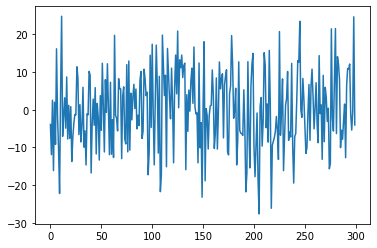

In [8]:
plt.plot(y)

### Begin Modeling

In [9]:
gram = phi.t().matmul(phi)
eigs, evecs = np.linalg.eig(gram)
eigs = np.real(eigs)

In [10]:
order_to_add = np.random.permutation(nx)

In [11]:
keepers = []
eigs = torch.zeros(nx, P)
func_eigs = []

for ii, idx in enumerate(order_to_add):
    keepers.append(idx)
    phi_temp = phi[keepers,:]
    
    posterior_covariance = post_cov(phi_temp, sig, prior_cov)
    evals, _ = np.linalg.eig(posterior_covariance)
    eigs[ii, :] = torch.FloatTensor(np.real(evals))
    
    function_covariance = func_cov(phi_temp, sig, prior_cov)
    evals, _ = np.linalg.eig(function_covariance)
    func_eigs.append(torch.FloatTensor(np.real(evals)))

In [12]:
def effective_dimension(eigs, alpha=1.):
    nx = eigs.size(0)
    eff_dim = torch.zeros(nx)
    for ii in range(nx):
        eff_dim[ii] = torch.sum(eigs[ii, :].div(eigs[ii, :] + alpha))
        
    return eff_dim

In [13]:
alpha = 5.
eff_dim = effective_dimension(eigs, alpha=alpha)
func_eff_dim = [torch.sum(ee.div(ee + alpha)) for ee in func_eigs]

In [14]:
import seaborn as sns

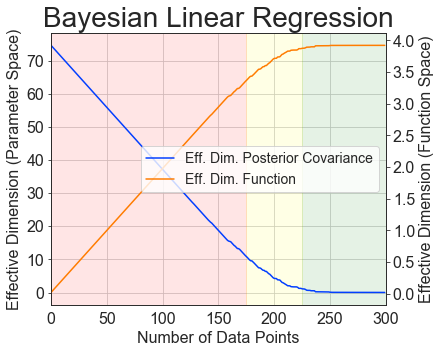

In [48]:
title_fs = 28
ax_fs = 16
leg_fs = 14
tick_size = 16

sns.set_style("white")
colors = sns.color_palette("bright")
# colors = ["537EC5", "F39422"]

fig, ax1 = plt.subplots(figsize=(6, 5))
l1, = ax1.plot(eff_dim, color=colors[0], label="Eff. Dim. Posterior Covariance")
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax1.grid()

ax2 = ax1.twinx()
l2, = ax2.plot(func_eff_dim, color=colors[1], label="Eff. Dim. Function")

# l3 = ax1.axvline(200, color='k', label="Number of Parameters", linestyle=":")
plt.title("Bayesian Linear Regression", fontsize=title_fs)
ax1.set_xlabel("Number of Data Points", fontsize=ax_fs)
ax1.set_ylabel("Effective Dimension (Parameter Space)", fontsize=ax_fs)
ax2.set_ylabel("Effective Dimension (Function Space)", fontsize=ax_fs)

plt.xlim(0, nx)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

ax1.axvspan(0, 175, alpha=0.1, color='red')
ax1.axvspan(175, 225, alpha=0.1, color='yellow')
ax1.axvspan(225, nx, alpha=0.1, color='green')

lines = [l1, l2]
plt.legend(lines, [l.get_label() for l in lines], loc="center right",
          fontsize=leg_fs)

# plt.legend(fontsize=leg_fs)
plt.savefig("./blr_eff_dim.pdf", bbox_inches="tight")


## Load in NN Data

In [25]:
import pickle

In [31]:
file = open('../../saved-experiments/bnn_regression_evals.pkl', 'rb')

In [32]:
data = pickle.load(file)
file.close()

In [46]:
data[0][0].shape

(286,)